# MIND Dataset: modeling

After checking the basics of our dataset, we're going to start our
modeling work. While doing this, we'll also look to encapsulate the code
into an API that would be easily useable elsewhere. The API won't be
*exactly* `sklearn`-compatible, but we should aim for something close.

We'll gradually build that up over time.

In [1]:
from pathlib import Path
import sys
from typing import List

import gensim
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.plots import (
    plot_convergence,
    plot_histogram,
    plot_objective_2D,
    plot_objective
)
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from umap import UMAP

sys.path.append("../src")
datapath = Path("../data")

## Load data

We're going to load up our data using our processing routines. We have
moved these out into their own `src` directory that we'll be able to use
in the future. This set-up is not the best, but works for the experiment
that we're running.

In [2]:
import data  # ../src/data

results = data.load_mind(datapath)
df_behavior = results["behaviors"]
df_news = results["news"]

del results

df_behavior.info()
df_behavior.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147870 entries, 0 to 156963
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   impression_id  147870 non-null  int64         
 1   user_id        147870 non-null  object        
 2   ts             147870 non-null  datetime64[ns]
 3   dt             147870 non-null  datetime64[ns]
 4   arr_item       147870 non-null  object        
 5   n_item         147870 non-null  float64       
 6   arr_click      147870 non-null  object        
 7   n_click        147870 non-null  int64         
 8   arr_skip       147870 non-null  object        
 9   n_skip         147870 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 12.4+ MB


impression_id user_id                  ts         dt  \
0              1  U13740 2019-11-11 09:05:58 2019-11-11   
1              2  U91836 2019-11-12 18:11:30 2019-11-12   
2              3  U73700 2019-11-14 07:01:48 2019-11-14   
3              4  U34670 2019-11-11 05:28:05 2019-11-11   
4              5   U8125 2019-11-12 16:11:21 2019-11-12   

                                            arr_item  n_item arr_click  \
0  [N55189, N42782, N34694, N45794, N18445, N6330...     9.0  [N55689]   
1  [N31739, N6072, N63045, N23979, N35656, N43353...    82.0  [N17059]   
2  [N10732, N25792, N7563, N21087, N41087, N5445,...    16.0  [N23814]   
3  [N45729, N2203, N871, N53880, N41375, N43142, ...    10.0  [N49685]   
4                   [N10078, N56514, N14904, N33740]     4.0   [N8400]   

   n_click                                           arr_skip  n_skip  
0        1                                           [N35729]       1  
1        1  [N20678, N39317, N58114, N20495, N42977, N2240...      10  
2        1  [N50014, N23877, N35389, N49712, N16844, N5968...      35  
3        1                           [N35729, N33632, N27581]       3  
4        1  [N39985, N3605, N16096, N22407, N60408, N61497...      68

From the above, we can form our sequences in a number of ways:

- use the last item in `arr_item` as the target for either the remaining
  sequence or the last *n* items
- use the first item in `arr_click` as the target for the either full
  `arr_item` sequence or the last *n* items
- use any of the items in `arr_click` as the target for either the full
  `arr_item` sequence or the last *n* items

We also have the items that were skipped. We can use this to improve our
training or evaluation in a number of ways:

- use skipped items as explicit negative cases
- evaluate our model lower if it highly predicts one of those items
  (like the `NDCG@X` for negative samples)
- ignore them

We'll think more on that shortly.

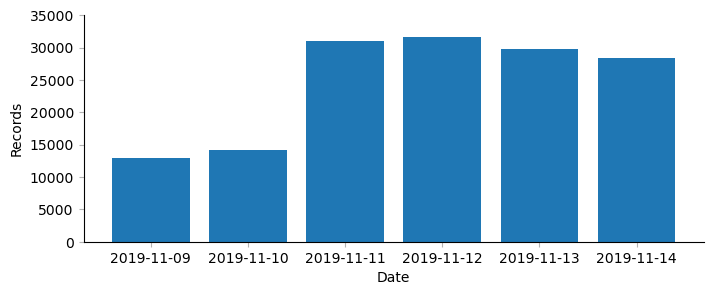

In [3]:
df_plot = (df_behavior
    .groupby("dt")
    .agg(n_record=("impression_id", "count"))
    .reset_index()
)
# df_plot.head()

fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
ax.bar("dt", "n_record", data=df_plot, tick_label=df_plot.dt.dt.date)
ax.set(ylim=(0, 35000), ylabel="Records", xlabel="Date")
ax.tick_params("both", color="#b2b2b2")
ax.spines["right"].set_color(None)
ax.spines["top"].set_color(None)

We only have a few days of data. Like any recommender system, it should
work for the future and for users that were not seen during training.
Thankfully there are additional datasets that we could use to evaluate
this process, so we won't worry too much about that now.

If we were doing this for real, we'd want to do the following:

- train the document embeddings on `X` days of data
- predict for the `X+1`th day
- holdout a subset of users that show up in the `X+1`th day from *all*
  previous data and evaluate them separately

The above will help capture how the model does in the future (and could
be used to gauge when retraining might be necessary) as well as how good
it might perform on out-of-sample records, like a new user.

## Create model

We're going to train a simple `Word2Vec` model on our sequences and
evaluate it using `NCDG@10`. [Normalized discounted cummulative gain][1]
is a ranking measure that tries to optimize for two things:

- the relevant items show up in the top `X` of the list; and
- the relevant items show up *higher* in that list than other items

This ranking metric is helpful when a small set of items might be
relevant for the search/recommendation. In our case, this will try to
move our target new article higher in the list of articles.

Given that we are calculating at a threshold, there's the possibility
that *no* relevant items are "above the fold" which would result in
`NDCG@X = 0`. In the case where there is one relevant item in the first
spot and a second relevant item "below the fold", we would have
`NDCG@X = 1` since the item list is reduced before calculation. This
choice reflects the usual situation of not getting "feedback" on items
that are never shown to the user, so we don't have an assessment on the
actual relevance.

[1]: https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG

In [4]:
def ndcg(relevances: np.array, k: int = 10) -> float:
    _rel = relevances[:k]
    if np.sum(_rel) == 0:
        return 0
    discount = np.log2(np.arange(1, _rel.shape[0] + 1) + 1)
    dcg = np.sum(_rel / discount)
    ideal_scores = np.array(sorted(_rel, reverse=True))
    idcg = np.sum(ideal_scores / discount)
    return dcg / idcg

_relevances = np.array([1, 0, 0, 0, 0])
assert np.isclose(ndcg(_relevances), 1.0, rtol=0.001), ndcg(_relevances)
_relevances = np.array([0, 0, 0, 0, 0])
assert np.isclose(ndcg(_relevances), 0.0, rtol=0.001), ndcg(_relevances)
_relevances = np.array([0, 1, 0, 0, 0])
assert np.isclose(ndcg(_relevances), 0.631, rtol=0.001), ndcg(_relevances)
# example from https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG
_relevances = np.array([3, 2, 3, 0, 1, 2])
assert np.isclose(ndcg(_relevances), 0.961, rtol=0.001), ndcg(_relevances)


We'll train our model with some performance callbacks such that we can
determine what an "optimal" tune may look like. To start, we will use
a basic set of parameters and fix our epochs. We will still use `skopt`
for our optimization routine. From our `behaviors` dataframe, we'll need
to do some last preprocessing to generate our sequences. We'll split the
last day off as validation.

In [5]:
holdout_df = df_behavior.query("dt == '2019-11-14'")
training_df = df_behavior.query("dt != '2019-11-14'")

# holdout_df.shape, training_df.shape
arr_train, arr_validation = data.prepare_sequences_basic(training_df)

Our training arrays are the sequences that we will use to determine the
item embeddings using `word2vec`. Our validation arrays are single-item
arrays for the end of each sequence. This item should be "predicted" by
the training sequence (or an ending subset of) at the same index.

During our optimization loop, we are going to do the following:

- train our `word2vec` model on the training arrays
- use the training arrays as our ground truth for the test array
- extract the top `K` closest items to the vector formed from from the
  query items
- calculate `NDCG@K` for all results and take the average
- minimize `1 - avg(NDCG@K)` to fit with `skopt`'s framework

The process above is very similar to what we set up previously. We'll
set up some additional functions that will eventually get extracted out
into a separate package.

In [6]:
def train_embeddings(
    # arr_training: List[List[str]],
    # copying gensim word2vec defaults
    window: int = 5,  # maximum distance between current and predicted
    sample: float = 0.001,  # threshold for downsampling higher-frequency words
    negative: int = 5,  # number of negative samples to use
    ns_exponent: float = 0.75,  # weight of sampling for negatives
    epochs: int = 5,
) -> gensim.models.keyedvectors.KeyedVectors:
    model = Word2Vec(
        arr_train,
        workers=8,
        vector_size=64,
        min_count=1,
        sg=1,
        window=window,
        sample=sample,
        # hs=hs,
        negative=negative,
        ns_exponent=ns_exponent,
        epochs=epochs,
    )
    return model.wv

def score_ndcgatk(
    embeddings: gensim.models.keyedvectors.KeyedVectors,
    arr_query: List[List[str]],
    arr_target: List[List[str]],
    k: int = 10
) -> float:
    _score = 0
    n_query = len(arr_query)
    n_query_skipped = 0
    assert len(arr_query) == len(arr_target)
    for _query, _target in zip(arr_query, arr_target):
        recommendations = _get_similar_items(_query, embeddings, k)
        target = _target[0]
        if recommendations and target in recommendations:
            _relevances = np.array([int(item == target) for item in recommendations])
            _score += ndcg(_relevances, k)
        else:
            n_query_skipped += 1
    if n_query == n_query_skipped:
        return 0
    return _score / (n_query - n_query_skipped), n_query_skipped


def _get_similar_items(
    query: List[str],
    embeddings: gensim.models.keyedvectors.KeyedVectors,
    k: int,
) -> List[str]:
    try:
        neighbors = embeddings.most_similar(positive=query, topn=k)
        recs = [item for item, _ in neighbors]
        return recs
    except KeyError:
        pass

We'll want to monitor this through `skopt`'s callbacks, so we can create
a `tqdm` callback to handle our optimization progress. We'll report the
`NDCG@K` metric here for exposure.

In [7]:
from tqdm import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs) -> None:
        self.desc = "NDCG:                 "  # 22
        self._bar = tqdm(desc=self.desc, **kwargs)
        
    def __call__(self, res) -> None:
        _min = 1 - res["func_vals"].min()
        try:
            _delta = res["func_vals"].std()
        except:
            _delta = 0
        self._bar.set_description(f"NDCG: {_min:7.5f} +/-{_delta:5.3f}")
        self._bar.update()
    

In [8]:
SPACE = [
    Integer(1, 25, name="window"),
    Real(0, 1e-5, name="sample"),
    Integer(5, 25, name="negative"),
    Real(-1, 1, name="ns_exponent"),
]

@use_named_args(dimensions=SPACE)
def f(
    # copying gensim word2vec defaults
    window: int = 5,  # maximum distance between current and predicted
    sample: float = 0.001,  # threshold for downsampling higher-frequency words
    negative: int = 5,  # number of negative samples to use
    ns_exponent: float = 0.75,  # weight of sampling for negatives
) -> float:
    embs = train_embeddings(
        # arr_train,
        window=window,
        sample=sample,
        negative=negative,
        ns_exponent=ns_exponent,
        epochs=50,  # previous 5, best NDCG@10: 1-0.28636 = 0.71364
        # almost all sequences have no relevant docs in the top 10
        # @5 epochs, ~2min/iter
        # @50 epoch, ~3min/iter
        # we can go to higher epoch numbers easily...that's good for
        # getting better results
        # I'm bumping to NDCG@@20 to get additional exposure and to help
        # convergence
    )
    score, _ = score_ndcgatk(embs, arr_train, arr_validation, k=20)
    return 1 - score

n_call = 100  # until we get the `tqdm` part right
result = gp_minimize(
    f,
    SPACE,
    n_calls=n_call,
    verbose=False,
    callback=[tqdm_skopt(total=n_call, ncols=80)],
)

NDCG: 0.40620 +/-0.069:  43%|█████▌       | 43/100 [2:34:57<4:27:59, 282.09s/it]/home/mikemoran/miniconda3/envs/sequence-embedding/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
NDCG: 0.40620 +/-0.068:  44%|█████▋       | 44/100 [2:37:46<3:51:32, 248.08s/it]/home/mikemoran/miniconda3/envs/sequence-embedding/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
NDCG: 0.40620 +/-0.068:  46%|█████▉       | 46/100 [2:42:47<2:57:20, 197.05s/it]/home/mikemoran/miniconda3/envs/sequence-embedding/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
NDCG: 0.40620 +/-0.067:  48%|██████▏      | 48/100 [2:47:23<2

For this data size, running 10 iterations in 18 minutes is not bad. We
should be good to optimize for a longer time period. Every 30 iterations
would be about 1 hour of runtime.

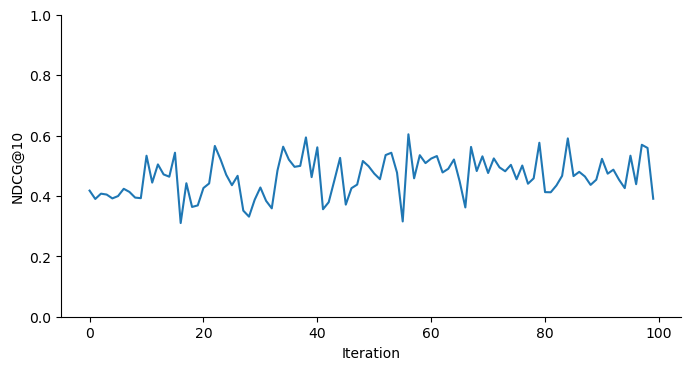

In [9]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(
    np.arange(result["func_vals"].shape[0]),
    1 - result["func_vals"],
)
ax.set(ylim=(0, 1), ylabel="NDCG@10", xlabel="Iteration")
ax.spines["right"].set_color(None)
ax.spines["top"].set_color(None)

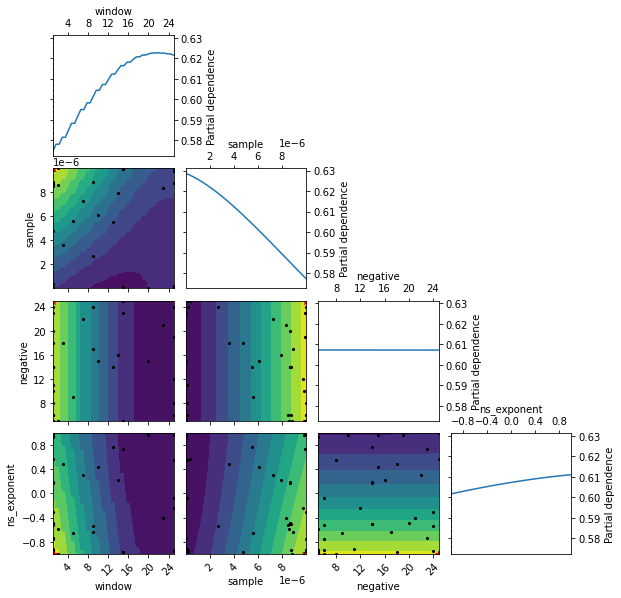

In [10]:
_ = plot_objective(
    result,
    plot_dims=["window", "sample", "negative", "ns_exponent"],
)

After 100 iterations, we've reached what may be considered a maximum
with `NDCG@10 = 0.714`. That's decent, but as noticed before, we may be
calculating this on a small subset of sequences.

If `gensim` fails to find a vector, we've just been ignoring that one
and using the results from the rest. For our final model, how common is
that occurance?

In [11]:
param_names = ["window", "sample", "negative", "ns_exponent"]

for _param, _name in zip(result.x, param_names):
    print(f"{_name} = {_param}")

window = 1
sample = 1e-05
negative = 25
ns_exponent = -1.0


From the parameters above, we would need to assemble a new embedding
model from our data, which would take a few minutes. Looking at the
objective plots above, it doesn't seem like we are highly dependent on
the values of `sample` or `negative`, and our range for `window` might
not be as large as it should otherwise be. The good news is that we do
see some minima so we may have a decent chance at good results.

Let's create a final model using these best parameters and use that to
check our results.

In [16]:
final_embedding = train_embeddings(
    window=1,
    sample=1e-5,
    negative=25,
    ns_exponent=-1.0,
)

In [18]:
score_ndcgatk(
    final_embedding,
    arr_train,
    arr_validation,
    k=20,
)

(0.33809416699195377, 119357)

Looking back, I only trained for 5 epochs for each model...what happens
as we increase the number of epochs we train for?

In [19]:
len(arr_train), 119357

(119532, 119357)

OK, as I feared, we're optimizing over less than 200 samples, not the
complete set. We'll need to rethink extracting our vectors out and
comparing them so that we don't have that issue.

Rethink what you're doing above for the `NDCG@K` calculation and make it
better.

In [15]:
for i, _ in enumerate(tqdm(arr_train)):
    _res = _get_similar_items(arr_train[1], final_embedding, k=20)
    if not _res:
        print(i)

100%|██████████| 119532/119532 [01:28<00:00, 1345.26it/s]


Hmm...from the above, the issue isn't that we aren't building up vectors
for our items, but instead that we aren't surfacing documents into those
top 10 results. I wonder if it makes sense to build up something that
optimizes for `NDCG@20` to find better hyperparameters, then drop the
`@K` value lower while searching in a smaller space?

But first, one of our issues is likely still the small epoch number.
We'll rerun the above with 50 epochs per iteration and see where that
get's us.

## Conclusions

As the dataset authors mentioned, this is a difficult problem to solve
given the "cold start" issue. I'm not trying to build a perfect system
here, just testing to see if I can get something decent-ish.

Given the high cardinality of the items and the cold start issue, it is
not a wonder that this relatively simple model with no other thought
hasn't done that well. Thankfully, in my real line of work, our issues
are different, so we could still use this technique. A closer analog
would be the item "topics" or "subtopics".

For our next step, let's create some topic/subtopic models, including
simple baselines, and see how we do from there.